In [1]:
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf


from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_map import SortedConv2DWithMap
from layers.sym_conv import SymConv2D
from layers.antisym_conv import AntiSymConv2D

from layers.geometric_confusion import GConfusion
import datetime


KeyboardInterrupt: 

In [ ]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()
#tf.debugging.disable_traceback_filtering()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_xla())
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__ )

Num GPUs Available:  1
True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.11.0-dev20220812


In [ ]:
input_net = Input((32, 32, 3))

s = SymConv2D(filters=8, activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
s = GConfusion(patch_size=8, prob=0.7, max=2)(s)

a = AntiSymConv2D(filters=8, activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
a = GConfusion(patch_size=8, prob=0.7, max=2)(a)
y =  layers.Add()([s,a])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

#y = GConfusion(patch_size=8, prob=0.4, max=10.0)(y)


s = SymConv2D(filters=16, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
s = GConfusion(patch_size=8, prob=0.7, max=8)(s)

a = AntiSymConv2D(filters=16, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
a = GConfusion(patch_size=8, prob=0.7, max=8)(a)
y =  layers.Add()([s,a])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) #y = GConfusion(patch_size=8, prob=0.4, max=10.0)(y)

s = SymConv2D(filters=32, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
s = GConfusion(patch_size=8, prob=0.7, max=32)(s)

a = AntiSymConv2D(filters=32, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
a = GConfusion(patch_size=8, prob=0.7, max=32)(a)
y =  layers.Add()([s,a])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 


y = layers.Flatten()(y)
y = layers.Dense(256, activation=ReLU())(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sym_conv2d_6 (SymConv2D)       (None, 32, 32, 8)    80          ['input_3[0][0]']                
                                                                                                  
 anti_sym_conv2d_6 (AntiSymConv  (None, 32, 32, 8)   104         ['input_3[0][0]']                
 2D)                                                                                              
                                                                                                  
 g_confusion_6 (GConfusion)     (None, 32, 32, 8)    0           ['sym_conv2d_6[0][0]']     

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


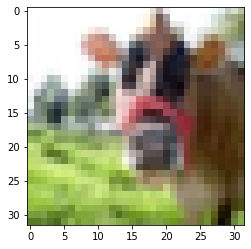

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [ ]:
model = Model(inputs = input_net, outputs = output_net)


optimizer = tf.keras.optimizers.RMSprop()


model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)



batch_size = 256
epochs = 30
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
196/196 [==============================] - 32s 121ms/step - loss: 18.4260 - accuracy: 0.0103 - top-5-accuracy: 0.0571 - val_loss: 5.8084 - val_accuracy: 0.0114 - val_top-5-accuracy: 0.0551
Epoch 2/30
196/196 [==============================] - 22s 115ms/step - loss: 4.6134 - accuracy: 0.0099 - top-5-accuracy: 0.0482 - val_loss: 5.3037 - val_accuracy: 0.0083 - val_top-5-accuracy: 0.0468
Epoch 3/30
196/196 [==============================] - 22s 111ms/step - loss: 4.6167 - accuracy: 0.0091 - top-5-accuracy: 0.0461 - val_loss: 4.9490 - val_accuracy: 0.0120 - val_top-5-accuracy: 0.0483
Epoch 4/30
196/196 [==============================] - 22s 111ms/step - loss: 4.6068 - accuracy: 0.0094 - top-5-accuracy: 0.0471 - val_loss: 4.7943 - val_accuracy: 0.0087 - val_top-5-accuracy: 0.0465
Epoch 5/30
196/196 [==============================] - 22s 111ms/step - loss: 4.6078 - accuracy: 0.0093 - top-5-accuracy: 0.0459 - val_loss: 4.7544 - val_accuracy: 0.0116 - val_top-5-accuracy: 0.0485
Epoc

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
def rotateDataset(x,y, maxRot = 360, h=32, w=32, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    datagen.fit(x.reshape(x.shape[0], 32, 32, 3))
    #out = datagen.flow(x.reshape(x.shape[0], h, w, 1), y.reshape(y.shape[0], -1), batch_size=batch_size)

    out = datagen.flow(x.reshape(x.shape[0], h, w, 3),  y, batch_size=batch_size)


    return  out

In [ ]:
score = model.evaluate(rotateDataset(x_test, y_test, maxRot=90), verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

100/100 [==============================] - 7s 57ms/step - loss: 4.4474 - accuracy: 0.0369 - top-5-accuracy: 0.1298
Test loss: 4.447370529174805
Test accuracy: 0.03689999878406525


In [ ]:


def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

for X,Y in rotateDataset(x_test, batch_size=1, maxRot=360):
    print(np.argmax(Y), np.argmax(model.predict(X)))
    plt.figure(0)  
    get_layer_output = K.function([model.input], model.layers[0].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out[0].shape)
    plt.imshow(layer_out[0], cmap='gray_r')   
    plt.figure(1)  
    get_layer_output = K.function([model.input], model.layers[-1].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out[0].shape)
    plt.imshow(layer_out[0],  cmap='gray_r')   

    break

TypeError: rotateDataset() missing 1 required positional argument: 'y'

In [ ]:

n = 109
X = x_test[n]
print(X.shape)

get_layer_output = K.function([model.input], model.layers[1].output)
out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])

get_layer_output = K.function([model.input], model.layers[2].output)
out_shift = np.array(get_layer_output(np.expand_dims(X, axis=0)))





plt.figure(1)  
print('o', out_shift.shape)
im = plt.imshow(out[:, 10, 5, :], cmap='gray')   
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(2)  
im = plt.imshow(out_shift[:,10, 5, :], cmap='gray')  
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

print(map.shape)
print(map[0, 10, 5])



plt.figure(3)  
im = plt.imshow(X, cmap='gray')  

#plt.colorbar(im, ticks=range(32), orientation="horizontal")
        

plt.figure(4)  
im = plt.imshow(map[0], cmap='gray')  

plt.colorbar(im, ticks=range(32), orientation="horizontal")
        


(32, 32, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    '''if 'conv' not in layer.name:
        raise ValueError('Layer must be a conv. layer')'''
    # get filter weight
    filters, biases = layer.get_weights()
    print("biases shape : ", biases.shape)
    print("filters shape : ", filters.shape)

    return (filters)
    #print(layer.name, filters.shape)

# I use sobel to determine the dominant orientation of the filter
def getSobelAngle(f):

    s_h = sobel_h(f)
    s_v = sobel_v(f)

    return np.abs((np.degrees(np.arctan2(s_h,s_v))% 360))
def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)

In [ ]:

LAYER = 1
filters = get_filter(LAYER)

FILTER = [7] #list(range(filters.shape[-1]))
CHANNEL = list(range(filters.shape[-2]))


thetas = []
for i, channel in enumerate(CHANNEL):
    for filter in FILTER:
        
        f = filters[:,:,:, filter]
        f = f[:,:, channel]
        s, a = getSymAntiSym(f)
        #print("==========(s)
        #print(a)
        #print(getSobelAngle(f)[1, 1])
        sym_mag = np.linalg.norm(s) 
        anti_mag = np.linalg.norm(a) 
        if anti_mag > 0:

            theta = getSobelAngle(f)
            theta = theta[theta.shape[0]//2, theta.shape[1]//2]
            thetas.append(theta)

plt.hist(thetas, bins=45)
plt.xticks(np.arange(0, 360, step=45), size='small', rotation=0)    

plt.show()
print(len(thetas))
print(thetas)

: 